In [24]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
import time

from util import *

## Load the COMPAS dataset

In [25]:
# Load COMPAS data
X,y,sensitive_features = load_compas_X_y_s(datasets)

# Split dataset into 4 sub-groups and retrieve the indices
subgroups_indices = get_lable_group_index(X, y, sensitive_features)

## Define a model for the study of long-term impact of fairness contraints in COMPAS

### Initial qualification rates
We randomly sample beginning points from 0 to 1. As shown in the following figure. 

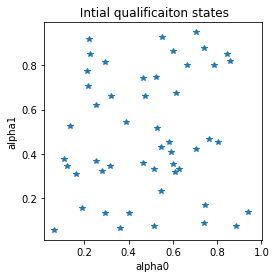

In [26]:
# Define the start point of qualification rates
np.random.seed(777)

NUM_SAMPLES = 50
P0 = 0.8
alpha0List = np.random.uniform(0.05,0.95,NUM_SAMPLES)
alpha1List = np.random.uniform(0.05,0.95,NUM_SAMPLES)


plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*',label='Initial points')

plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.axis('square')
plt.title(" Intial qualificaiton states")
plt.show()

### Transition probability 
-  $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, represented by an array T[ y, a, s]: the probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e.,
- The following defined transition is under Condition 1(ii) in the paper.


In [27]:
# Define the transition matrix under Condition 1(i)
# T[0,0,0] = 0.9
# T[0,1,0] = 0.2
# T[1,0,0] = 0.2
# T[1,1,0] = 0.1

# T[0,0,1] = 0.6 # "Caucasian"
# T[0,1,1] = 0.5
# T[1,0,1] = 0.5
# T[1,1,1] = 0.4


# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
T = np.zeros((2, 2, 2))
T[0,0,0] = 0.1
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.9

T[0,0,1] = 0.4 # "Caucasian"
T[0,1,1] = 0.2
T[1,0,1] = 0.2
T[1,1,1] = 0.6



### Dynamics
$\alpha^s_{t+1} = g^{0s}_t + (g^{1s}_t-g^{0s}_t) \alpha^s_t$.  
- $g^{0s}_t = T[0,0,s]\mathbb{E}_{X\mid 0,s}(\hat{Y} = 0) + T[0,1,s] \mathbb{E}_{X\mid 0,s}(\hat{Y} = 1)$  
- $g^{1s}_t = T[1,0,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 0) + T[1,1,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 1)$
- T[ y, a, s] represents $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$.  
- E[ y, a, s] represents $\mathbb{E}_{X\mid y,s}(\hat{Y} = a)$.

In [28]:
def dynamics(alpha,T,E,group):
    g0 = T[0,0,group]*E[0,0,group] + T[0,1,group]*fprE[0,1,group]
    g1 = T[1,0,group]*E[1,0,group] + T[1,1,group]*E[1,1,s]
    return alpha*g1 + (1-alpha)*g0


In [29]:
def transition(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*fpr + T[0,1,group]*(1-fpr)
    g1 = T[1,0,group]*(1-tpr) + T[1,1,group]*tpr
    return alpha*g1 + (1-alpha)*g0

## The evolution trajectory of qualification states   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

In [30]:
def update_qualification_rates(alpha0, alpha1, ps, T, eva_classifier_fn,
                               X, y, sensitive_features, subgroups_indices):
    # Step 1: Compute ratios
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    #  Step 2: sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    #  Step 3: train (fair) classifiers, and estimate the quantity for dynamics
    pr,acc,tpr,fpr = eva_classifier_fn(X_train,y_train,sensitive_features_train)

    # Step 4: Update qualification rates
    alpha0_next = transition(alpha0, tpr["African-American"], fpr["African-American"], T, group = 0)
    alpha1_next =  transition(alpha1,tpr["Caucasian"],fpr["Caucasian"],T, group = 1)
    return alpha0_next,alpha1_next

### Evolution behavior in the UN case
**Evolution behavior.** From one sample result, we can see the evolution behavior. The figure indicates that in the UN case, qualification rates converge to an unique equiibria.

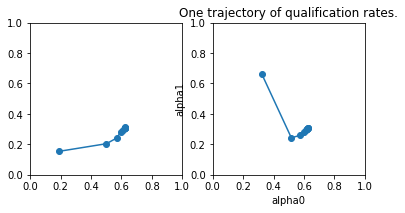

In [32]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                    X, y, sensitive_features, subgroups_indices)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha0_un_evolution,alpha1_un_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.title("One trajectory of qualification rates.")
plt.show()


**Equilibrium.** By study 50 different beginning points, we plot the last 5-interation results. It shows that there is one unique equilibria in the UN case.

49

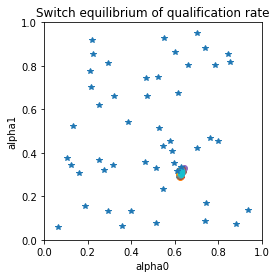

In [33]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                    X, y, sensitive_features, subgroups_indices)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)
        
    plt.axis('square')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_un_evolution[-5:],alpha1_un_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*')
plt.title("Switch equilibrium of qualification rate")
plt.show()


### The DP case
**Evolution behavior.** The figure indicates that in the DP case, qualification rates converge to an unique equiibria.

Text(0.5, 1.0, 'One trajectory of qualification rates under DP.')

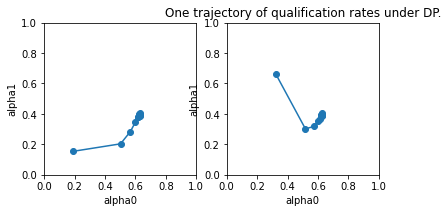

In [34]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_dp,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_dp_evolution,alpha1_dp_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under DP.")


**Equilibrium.** By study 50 different beginning points, we plot the last 5-interation results. It shows that there is one unique equilibria in the DP case.

49

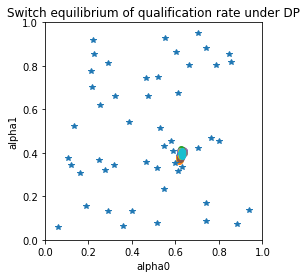

In [35]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_dp,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)
        
    plt.axis('square')
    plt.plot(alpha0_dp_evolution[-5:],alpha1_dp_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.plot(alpha0List,alpha1List,'*')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.title("Equilibrium of qualification rate under DP")
plt.show()


### The EO case

**Evolution behavior.**

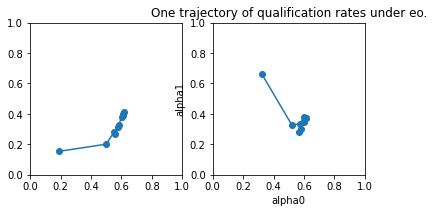

In [36]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eo_evolution=[alpha0]
    alpha1_eo_evolution=[alpha1]
    t = 0
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eo,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eo_evolution.append(alpha0)
        alpha1_eo_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha0_eo_evolution,alpha1_eo_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.title("One trajectory of qualification rates under eo.")

plt.show()



**Equilibrium.**  There is one unique equilibria.

49

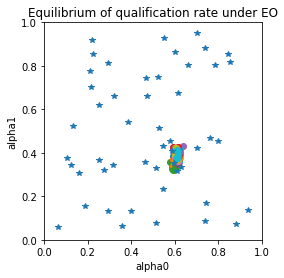

In [37]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10

plt.figure()
NUM_SAMPLES = 50
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eo_evolution=[alpha0]
    alpha1_eo_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eo,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eo_evolution.append(alpha0)
        alpha1_eo_evolution.append(alpha1)
    plt.axis('square')
    plt.plot(alpha0_eo_evolution[-5:],alpha1_eo_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.plot(alpha0List,alpha1List,'*')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.title("Equilibrium of qualification rate under EO")
plt.show()


### The EqOpt case
**Evolution behvior.** 

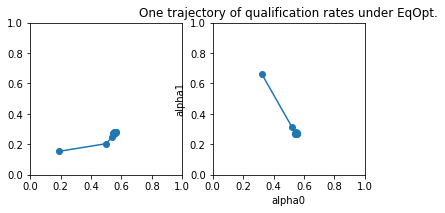

In [38]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eqopt,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)

    plt.subplot(1,2,1+k)
    plt.axis('square')
    plt.plot(alpha0_eqopt_evolution,alpha1_eqopt_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)  
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.title("One trajectory of qualification rates under EqOpt.")
plt.show()

**Equilibrium.** The figure shows that there is an unique equilibria in the case of EqOpt.

49

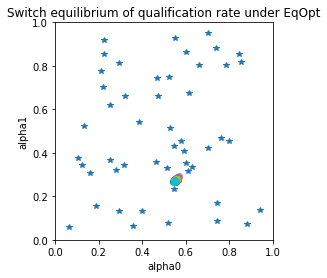

In [39]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eqopt,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)

    plt.axis('square')
    plt.plot(alpha0_eqopt_evolution[-5:],alpha1_eqopt_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.plot(alpha0List,alpha1List,'*')
plt.title("Switch equilibrium of qualification rate under EqOpt")
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.show()


## Long-term impact of fairness constraints
It turns out that under Condition 1(ii),  
- Fairness constraints promote the equality.
- DP and EO help increase the overall qualification rate, whereas EqOpt decreases it.

In [40]:
print('The equality measure of UN: ', alpha0_un_evolution[-1]-alpha1_un_evolution[-1])
print('The equality measure of DP: ', alpha0_dp_evolution[-1]-alpha1_dp_evolution[-1])
print('The equality measure of EO: ', alpha0_eo_evolution[-1]-alpha1_eo_evolution[-1])
print('The equality measure of EqOpt: ', alpha0_eqopt_evolution[-1]-alpha1_eqopt_evolution[-1])

The equality measure of UN:  0.3206750297169064
The equality measure of DP:  0.24331419029921847
The equality measure of EO:  0.23518116760220786
The equality measure of EqOpt:  0.2818428765850199


In [41]:
print('The overall qualification rate measure of UN: ', alpha0_un_evolution[-1]+alpha1_un_evolution[-1])
print('The overall qualification rate measure of DP: ', alpha0_dp_evolution[-1]+alpha1_dp_evolution[-1])
print('The overall qualification rate measure of EO: ', alpha0_eo_evolution[-1]+alpha1_eo_evolution[-1])
print('The overall qualification rate measure of EqOpt: ', alpha0_eqopt_evolution[-1]+alpha1_eqopt_evolution[-1])

The overall qualification rate measure of UN:  0.9396674255313532
The overall qualification rate measure of DP:  1.0141503181286475
The overall qualification rate measure of EO:  0.9851182738934138
The overall qualification rate measure of EqOpt:  0.8211898979022403
